# Model Training

Contents
- Process data into one-hot encoded sequence vectors and targets.
- Break into train, validation, and test sets.
- Perform a modest hyper-parameter search.
- Conclude that a variety of hyperparameters result in similar performance.
- Train and save a model to use in rest of analysis.

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
%matplotlib inline

In [2]:
from genome import Genome
genome = Genome('/Users/jpaggi/Downloads/MPRA/snps/hg19.fa')

In [45]:
cons = {}
with open('../anno/hg19.100way.phyloP100way.bp.bed') as fp:
    for line in fp:
        chrom, pos, _, score = line.strip().split()
        if chrom not in cons: cons[chrom] = {}
        cons[chrom][int(pos)] = float(score)

In [46]:
introns = {}
with open('../preprocessing/introns_to_mercer.tsv') as fp:
    for line in fp:
        chrom, start, end, _, pos, strand, _, bp = line.split('\t')[:8]
        bp, start, end = int(bp), int(start), int(end)
        
        three = end if strand == '+' else start  
        key = (chrom, three, strand)
        
        if not 5 < abs(bp - three) < 60:
            bp = -1
        
        if key not in introns: introns[key] = []
        assert bp not in introns[key], bp
        if bp != -1: introns[key] += [bp]

In [47]:
known   = {key: value for key, value in introns.items() if value}
missing = {key: value for key, value in introns.items() if not value}
print len(known)
print len(missing)

37110
169182


In [48]:
L = 70
bases = ['A', 'C', 'G', 'T']

def onehot(seq):
    X = np.zeros((len(seq), len(bases)))
    for i, char in enumerate(seq):
        X[i, bases.index(char)] = 1
    return X

X, y, chroms, threes, strands = [], [], [], [], []
for intron, bps in known.items():
    chrom, three, strand = intron
    if strand == '+':
        begin, stop = three - L, three
    else:
        begin, stop = three, three + L
    
    # Get features
    seq = genome.get_seq(chrom, begin, stop, strand)
    if 'N' in seq: seq = seq.replace('N', 'A')
    
    c = np.array([cons[chrom][pos] if pos in cons[chrom] else 0
                  for pos in range(begin, stop)]).reshape(-1, 1)
    if strand == '-': c = c[::-1]
    
    X += [np.hstack([onehot(seq), c]).reshape(1, 70, 5)]

    # Make target
    _y = np.zeros((stop - begin,))
    for bp in bps:
        if strand == '+':
            bp = L + bp - three
        else:
            bp = L - bp + three - 1
        _y[bp] = 1
    y += [_y]
    
    chroms += [chrom]
    if chrom == 'chr1':
        threes += [three]
        strands += [strand]

X, y = np.vstack(X), np.vstack(y)
print X.shape, y.shape, len(chroms), len(threes), len(strands)

(37110, 70, 5) (37110, 70) 37110 4306 4306


# Normalize CONS

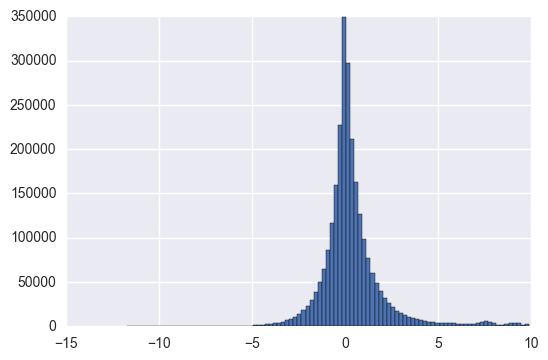

/Users/jpaggi/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


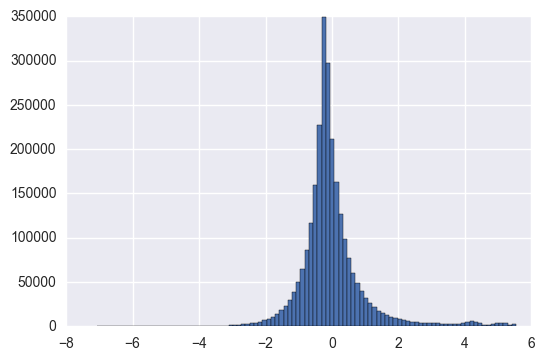

/Users/jpaggi/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


In [55]:
from sklearn.preprocessing import StandardScaler
cons = X[:, :, 4].flatten()
plt.hist(cons, bins = 100)
plt.show()
scaler = StandardScaler().fit(cons.reshape(-1, 1))
plt.hist(scaler.transform(cons), bins =100)
plt.show()

X[:, :, 4] = scaler.transform(cons).reshape(-1, L)

In [56]:
test = np.array(map(lambda x: x == 'chr1', chroms))
valid = np.array(map(lambda x: x in ('chr2', 'chr3', 'chr4', 'chr5'),
                     chroms))
train = np.array([not (t or v) for t, v in zip(test, valid)])
print sum(test),  sum(valid), sum(train)

X_train, X_valid, X_test = X[train], X[valid], X[test]
y_train, y_valid, y_test = y[train], y[valid], y[test]
print X_train.shape, X_valid.shape, X_test.shape
print y_train.shape, y_valid.shape, y_test.shape

4306 7093 25711
(25711, 70, 5) (7093, 70, 5) (4306, 70, 5)
(25711, 70) (7093, 70) (4306, 70)


In [57]:
def matching(preds, true):
    total, match = 0, 0
    for p, t in zip(preds, true):
        if np.argmax(p) in np.nonzero(t)[0]:
            match += 1
        total += 1
    return match, total

# Compute PWM as sanity check

In [58]:
K = 3
counts = np.zeros((2*K+1, 4))
for target, seq in zip(y_train, X_train):
    for bp in np.nonzero(target)[0]:
        if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
        counts = counts + seq[bp-K: bp+K+1, :4]
print counts.T

[[  5543.   4025.   6580.  30750.   7524.   8726.   7128.]
 [ 15038.   6727.  13676.   3718.  13751.  12028.  11222.]
 [  6480.   5016.   8802.   1699.   6906.   6065.   7984.]
 [ 11990.  23283.   9993.   2884.  10870.  12232.  12717.]]


# Look at cons

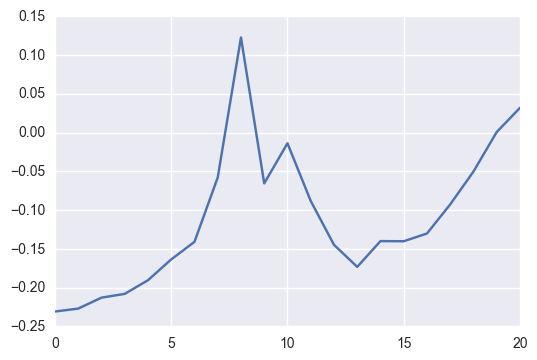

In [59]:
K = 10
counts = np.zeros((2*K+1))
total = 0.0
for target, seq in zip(y_train, X_train):
    for bp in np.nonzero(target)[0]:
        if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
        counts = counts + seq[bp-K: bp+K+1, 4]
        total += 1.0
plt.plot(counts / total)
plt.show()

# Model trainer

In [60]:
class ModelTrainer:
    def __init__(self, model):
        self.model = model
        self.train_auc = []
        self.train_match = []
        self.valid_auc = []
        self.valid_match = []
        
    def train(self, X_train, X_valid,
              y_train, y_valid, PATIENCE = 15, EPOCHS = 1000):
        print model.summary()
        for i in range(EPOCHS):
            model.fit(X_train, y_train, epochs = 1, verbose = 0)
            self._evaluate(X_train, X_valid, y_train, y_valid)
            if (i > PATIENCE
                and max(self.valid_match[-PATIENCE:])
                < max(self.valid_match)):
                break
            print i, self.valid_match[-1], self.train_match[-1]
        self._plot_scores()
        print max(self.valid_match), max(self.valid_auc)
    
    def predict(X):
        return self.model.predict(X)
                
    def _evaluate(self, X_train, X_valid, y_train, y_valid):
        valid_preds = self.model.predict_proba(X_valid, verbose=0)
        train_preds = self.model.predict_proba(X_train, verbose=0)
        self.valid_match += [matching(valid_preds, y_valid)[0]
                             / float(y_valid.shape[0])]
        self.train_match += [matching(train_preds, y_train)[0]
                             / float(y_train.shape[0])]
        self.valid_auc += [metrics.roc_auc_score(y_valid.flatten(),
                                                 valid_preds.flatten())]
        self.train_auc += [metrics.roc_auc_score(y_train.flatten(),
                                                 train_preds.flatten())]
    
    def _plot_scores(self):
        plt.plot(self.valid_match, label = 'Validation')
        plt.plot(self.train_match, label = 'Training')
        plt.ylabel('Match')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()
        
        plt.plot(self.valid_auc, label = 'Validation')
        plt.plot(self.train_auc, label = 'Training')
        plt.ylabel('auROC')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

In [61]:
from keras.models import Sequential
from keras.layers import Dense, Reshape, LSTM, Dropout
from keras.layers.convolutional import Conv2D
from keras import regularizers
from keras import optimizers
from keras.layers.wrappers import Bidirectional, TimeDistributed

# Cons version of Model all figs are based on

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 70, 64)            9728      
_________________________________________________________________
bidirectional_2 (Bidirection (None, 70, 64)            24832     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 70, 1)             65        
Total params: 34,625
Trainable params: 34,625
Non-trainable params: 0
_________________________________________________________________
None
0 0.481037642746 0.527322935708
1 0.547441139151 0.600871222434
2 0.577893698012 0.624363113064
3 0.601438037502 0.645404690599
4 0.604257718878 0.648632880868
5 0.629493867193 0.670802380304
6 0.644438178486 0.682392750185
7 0.649654589031 0.689743689471
8 0.651769350063 0.691066080666
9 0.657126744678 0.694060907783
10 0.658677569435 0.699583835712
11 0.659382489779 0.700283925168
12 0.664739

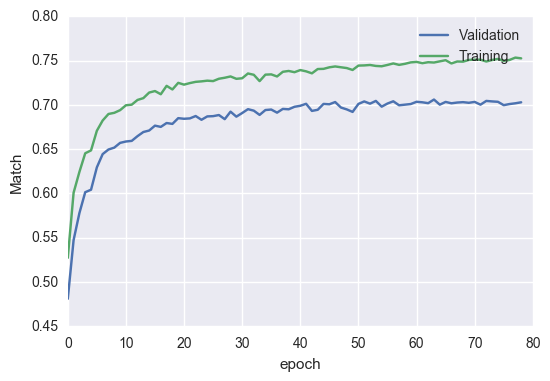

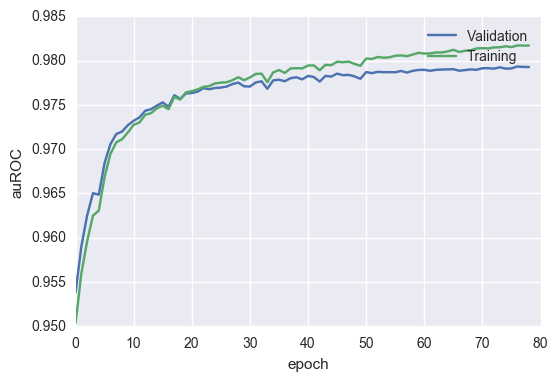

0.706048216552 0.979333154821


In [42]:
model = Sequential()

model.add(Bidirectional(LSTM(32, return_sequences = True,
                             dropout = 0.15, recurrent_dropout = 0.05),
                            input_shape = (L, 5)))
model.add(Bidirectional(LSTM(32, return_sequences = True,
                             dropout = 0.15, recurrent_dropout = 0.05)))

model.add(TimeDistributed(Dense(1, activation = 'sigmoid')))
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=0.001,
                                        beta_1=0.9,
                                        beta_2=0.999,
                                        epsilon=1e-08,
                                        decay=0.0))

ModelTrainer(model).train(X_train, X_valid,
                          y_train.reshape(-1, 70, 1), y_valid.reshape(-1, 70, 1))

In [43]:
model.save('../models/2layer_cons.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_5 (Bidirection (None, 70, 64)            9728      
_________________________________________________________________
bidirectional_6 (Bidirection (None, 70, 64)            24832     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 70, 1)             65        
Total params: 34,625
Trainable params: 34,625
Non-trainable params: 0
_________________________________________________________________
None
0 0.53108698717 0.577534907238
1 0.604680671084 0.645288009023
2 0.623290568166 0.668974368947
3 0.639644720147 0.68048695111
4 0.647680812068 0.68803235969
5 0.655293951783 0.691338337676
6 0.663189059636 0.701411847069
7 0.665444804737 0.70285091984
8 0.662343155223 0.703667690872
9 0.672071055971 0.708996149508
10 0.670379247145 0.71008517755
11 0.675031721415 0.712496596787
12 0.67926124347

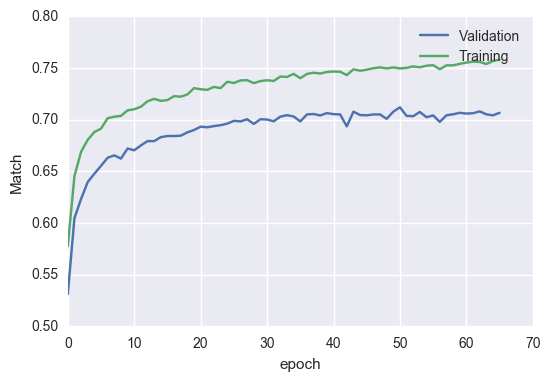

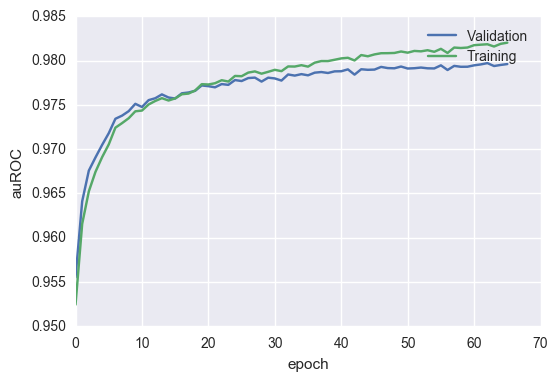

0.711969547441 0.979718528471


In [62]:
model = Sequential()

model.add(Bidirectional(LSTM(32, return_sequences = True,
                             dropout = 0.15, recurrent_dropout = 0.05),
                            input_shape = (L, 5)))
model.add(Bidirectional(LSTM(32, return_sequences = True,
                             dropout = 0.15, recurrent_dropout = 0.05)))

model.add(TimeDistributed(Dense(1, activation = 'sigmoid')))
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=0.001,
                                        beta_1=0.9,
                                        beta_2=0.999,
                                        epsilon=1e-08,
                                        decay=0.0))

ModelTrainer(model).train(X_train, X_valid,
                          y_train.reshape(-1, 70, 1), y_valid.reshape(-1, 70, 1))

In [63]:
model.save('../models/2layer_phyloP.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_9 (Bidirection (None, 70, 64)            9728      
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 70, 64)            24832     
_________________________________________________________________
time_distributed_5 (TimeDist (None, 70, 1)             65        
Total params: 34,625
Trainable params: 34,625
Non-trainable params: 0
_________________________________________________________________
None
0 0.529254194276 0.569444984637
1 0.589313407585 0.629963828711
2 0.596644579163 0.64365446696
3 0.618920062033 0.661195597215
4 0.648385732412 0.684026292248
5 0.649372620894 0.690482672786
6 0.657831665022 0.695383298977
7 0.659805441985 0.698066975225
8 0.668687438319 0.702500875112
9 0.670520231214 0.707323713586
10 0.670520231214 0.707595970596
11 0.675172705484 0.711446462604
12 0.6686874

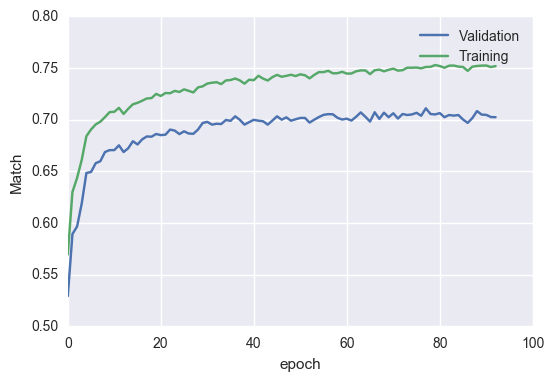

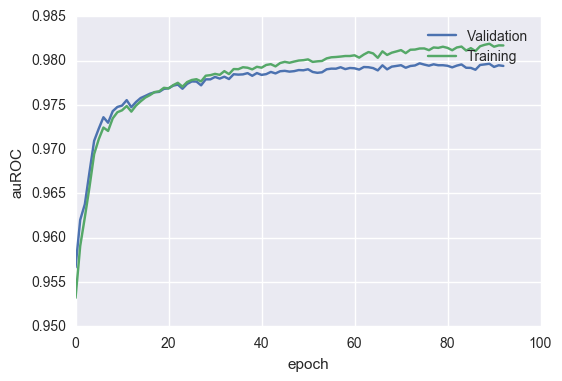

0.71098265896 0.979695163418


In [67]:
model = Sequential()

model.add(Bidirectional(LSTM(32, return_sequences = True,
                             dropout = 0.2, recurrent_dropout = 0.1),
                            input_shape = (L, 5)))
model.add(Bidirectional(LSTM(32, return_sequences = True,
                             dropout = 0.2, recurrent_dropout = 0.1)))

model.add(TimeDistributed(Dense(1, activation = 'sigmoid')))
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=0.001,
                                        beta_1=0.9,
                                        beta_2=0.999,
                                        epsilon=1e-08,
                                        decay=0.0))

ModelTrainer(model).train(X_train, X_valid,
                          y_train.reshape(-1, 70, 1), y_valid.reshape(-1, 70, 1))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_5 (Bidirection (None, 70, 64)            9728      
_________________________________________________________________
bidirectional_6 (Bidirection (None, 70, 64)            24832     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 70, 1)             65        
Total params: 34,625
Trainable params: 34,625
Non-trainable params: 0
_________________________________________________________________
None
0 0.703228535176 0.757030064953
1 0.703651487382 0.756174400062
2 0.705202312139 0.756952277235
3 0.707740025377 0.756913383377
4 0.708726913859 0.758624713158
5 0.705484280276 0.760413830656
6 0.70618920062 0.758235774571
7 0.706753136896 0.758702500875
8 0.704215423657 0.7597137412
9 0.706753136896 0.760569406091
10 0.706048216552 0.7597137412
11 0.706048216552 0.761502858699
12 0.70731707317

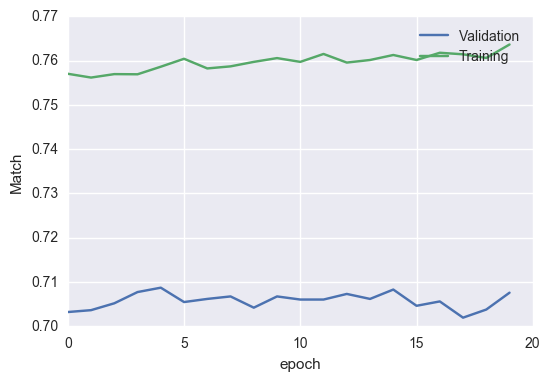

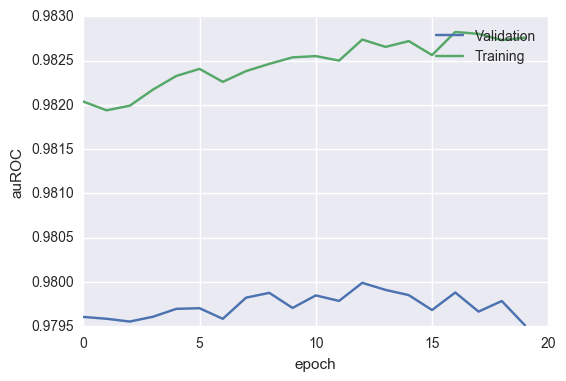

0.708726913859 0.979991093673


In [64]:
ModelTrainer(model).train(X_train, X_valid,
                          y_train.reshape(-1, 70, 1), y_valid.reshape(-1, 70, 1))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_7 (Bidirection (None, 70, 64)            9728      
_________________________________________________________________
bidirectional_8 (Bidirection (None, 70, 64)            24832     
_________________________________________________________________
time_distributed_4 (TimeDist (None, 70, 1)             65        
Total params: 34,625
Trainable params: 34,625
Non-trainable params: 0
_________________________________________________________________
None
0 0.522627943042 0.574384504687
1 0.571831383054 0.618956866711
2 0.585929789934 0.629380420832
3 0.597067531369 0.641593092451
4 0.60284787819 0.644743495002
5 0.610461017905 0.655594881568
6 0.60989708163 0.652600054451
7 0.612716763006 0.654194702656
8 0.612293810799 0.65466142896
9 0.624136472579 0.659367585858
10 0.625828281404 0.669363307534
11 0.62512336106 0.66597954183
12 0.61892006203

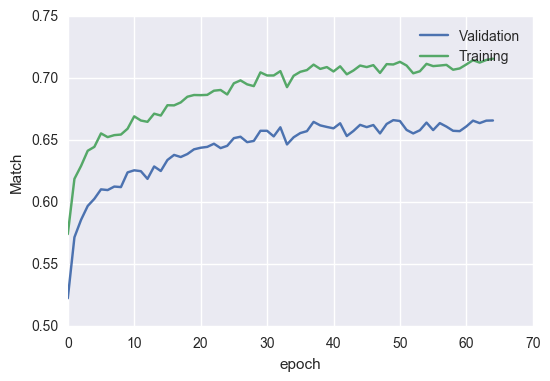

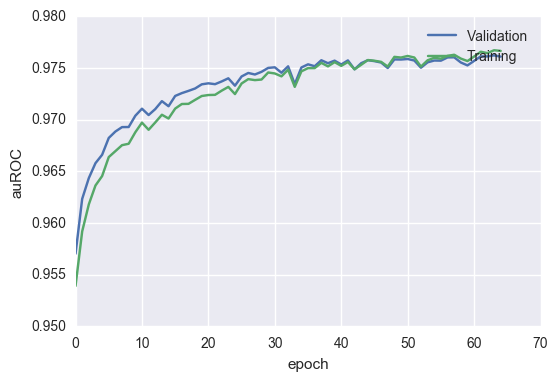

0.66629070915 0.976224443264


In [66]:
model = Sequential()
reg = regularizers.l2(0.0001)
model.add(Bidirectional(LSTM(32, return_sequences = True,
                             dropout = 0.15, recurrent_dropout = 0.05,
                            kernel_regularizer = reg,
                            recurrent_regularizer = reg,
                            bias_regularizer = reg),
                            input_shape = (L, 5)))
model.add(Bidirectional(LSTM(32, return_sequences = True,
                             dropout = 0.15, recurrent_dropout = 0.05,
                            recurrent_regularizer = reg,
                            bias_regularizer = reg)))

model.add(TimeDistributed(Dense(1, activation = 'sigmoid')))
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=0.001,
                                        beta_1=0.9,
                                        beta_2=0.999,
                                        epsilon=1e-08,
                                        decay=0.0))

ModelTrainer(model).train(X_train, X_valid,
                          y_train.reshape(-1, 70, 1), y_valid.reshape(-1, 70, 1))

In [44]:
model = Sequential()

model.add(Bidirectional(LSTM(48, return_sequences = True,
                             dropout = 0.15, recurrent_dropout = 0.05),
                            input_shape = (L, 5)))
model.add(Bidirectional(LSTM(48, return_sequences = True,
                             dropout = 0.15, recurrent_dropout = 0.05)))

model.add(TimeDistributed(Dense(1, activation = 'sigmoid')))
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=0.001,
                                        beta_1=0.9,
                                        beta_2=0.999,
                                        epsilon=1e-08,
                                        decay=0.0))

ModelTrainer(model).train(X_train, X_valid,
                          y_train.reshape(-1, 70, 1), y_valid.reshape(-1, 70, 1))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_3 (Bidirection (None, 70, 96)            20736     
_________________________________________________________________
bidirectional_4 (Bidirection (None, 70, 96)            55680     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 70, 1)             97        
Total params: 76,513
Trainable params: 76,513
Non-trainable params: 0
_________________________________________________________________
None
0 0.566333004371 0.607677647699
1 0.59932327647 0.646338143207
2 0.622585647822 0.668857687371
3 0.636261102495 0.684376336976
4 0.651910334132 0.692932985882
5 0.656421824334 0.695733343705
6 0.666572677287 0.703045389133
7 0.670097279007 0.706545836412
8 0.676018609897 0.71533584847
9 0.683208797406 0.71821399401
10 0.681657972649 0.718058418576
11 0.687015367263 0.725253782428
12 0.687438319

KeyboardInterrupt: 

In [ ]:
model.save('../models/2layer_cons_48.h5')

# Hyper param search

- In summary all of the models did about the same
- Maybe slight advantage to deeper models, but if two layers is good enough, I'm inclined to stay simple.

0 32 0.001 0.15 0.05 4
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_13 (Bidirectio (None, 70, 64)            9472      
_________________________________________________________________
bidirectional_14 (Bidirectio (None, 70, 64)            24832     
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 70, 64)            24832     
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 70, 64)            24832     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 70, 1)             65        
Total params: 84,033.0
Trainable params: 84,033
Non-trainable params: 0.0
_________________________________________________________________
None
0 0.465529395178
1 0.543070633018
2 0.590300296067
3 0.622444663753
4 0.63922176794
5 0.641054560835
6 0.6

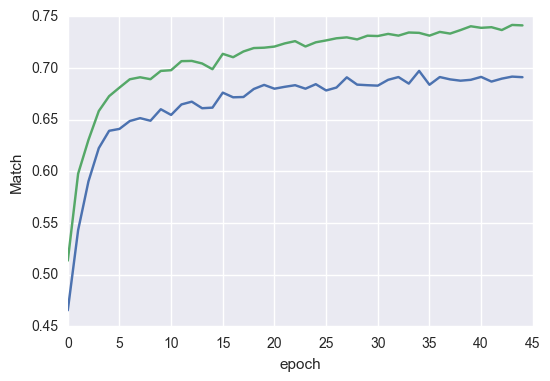

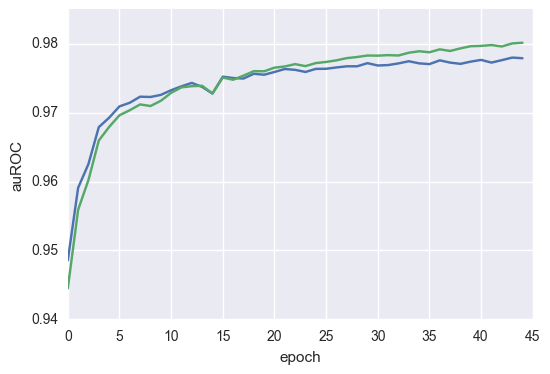

0.697166220217 0.977994772148
0 32 0.001 0.15 0.05 3
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_17 (Bidirectio (None, 70, 64)            9472      
_________________________________________________________________
bidirectional_18 (Bidirectio (None, 70, 64)            24832     
_________________________________________________________________
bidirectional_19 (Bidirectio (None, 70, 64)            24832     
_________________________________________________________________
time_distributed_4 (TimeDist (None, 70, 1)             65        
Total params: 59,201.0
Trainable params: 59,201
Non-trainable params: 0.0
_________________________________________________________________
None
0 0.500211476103
1 0.560693641618
2 0.588467503172
3 0.593965881855
4 0.620752854927
5 0.63569716622
6 0.641195544903
7 0.648526716481
8 0.651346397857
9 0.652897222614
10 0.657690680953
11 0.645284082899
12 

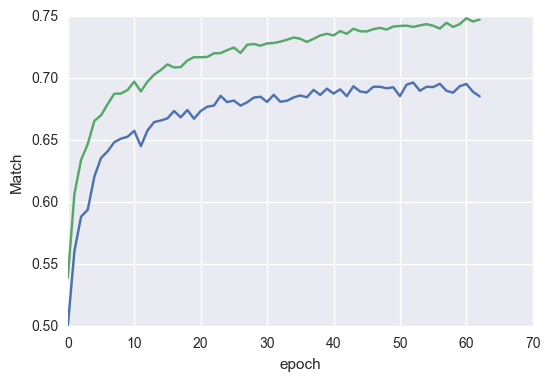

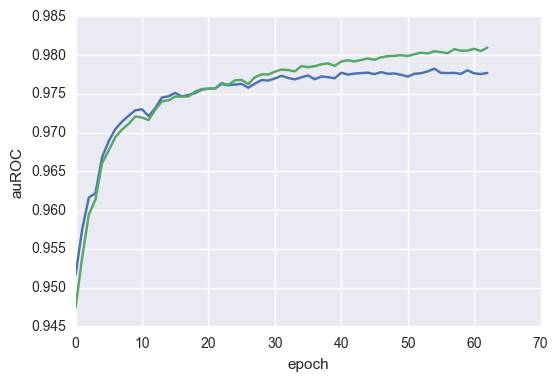

0.696602283942 0.978244236317
0 32 0.001 0.15 0.05 2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_20 (Bidirectio (None, 70, 64)            9472      
_________________________________________________________________
bidirectional_21 (Bidirectio (None, 70, 64)            24832     
_________________________________________________________________
time_distributed_5 (TimeDist (None, 70, 1)             65        
Total params: 34,369.0
Trainable params: 34,369
Non-trainable params: 0.0
_________________________________________________________________
None
0 0.456788382913
1 0.523050895249
2 0.582546172283
3 0.604821655153
4 0.621034823065
5 0.619202030171
6 0.626674185817
7 0.63569716622
8 0.641336528972
9 0.646975891724
10 0.644720146623
11 0.642323417454
12 0.656562808403
13 0.65571690399
14 0.661215282673
15 0.659946426054
16 0.65684477654
17 0.667841533907
18 0.662907091499
19 0.664457

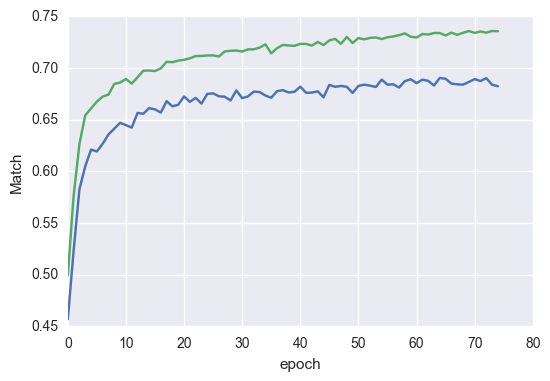

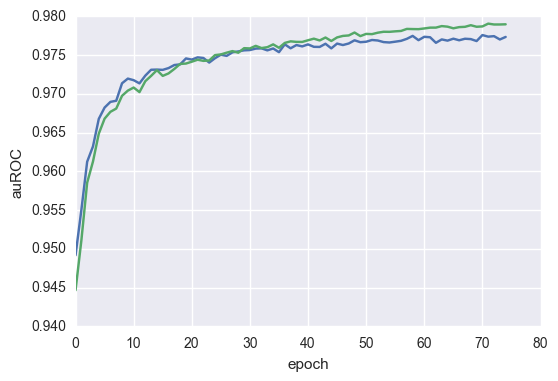

0.690398984915 0.977582799808
0 32 0.001 0.15 0.05 1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_22 (Bidirectio (None, 70, 64)            9472      
_________________________________________________________________
time_distributed_6 (TimeDist (None, 70, 1)             65        
Total params: 9,537.0
Trainable params: 9,537
Non-trainable params: 0.0
_________________________________________________________________
None
0 0.421260397575
1 0.429578457634
2 0.476385168476
3 0.534752572959
4 0.569434653884
5 0.574792048499
6 0.590018327929
7 0.586493726209
8 0.605244607359
9 0.611165938249
10 0.6145495559
11 0.624982376991
12 0.622162695615
13 0.627661074299
14 0.631749612294
15 0.635838150289
16 0.637529959115
17 0.639503736078
18 0.63809389539
19 0.64514309883
20 0.644156210348
21 0.642182433385
22 0.645566051036
23 0.645425066967
24 0.648526716481
25 0.652051318201
26 0.6497955731
27 0

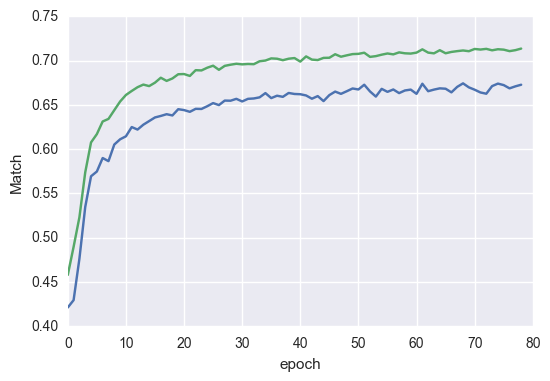

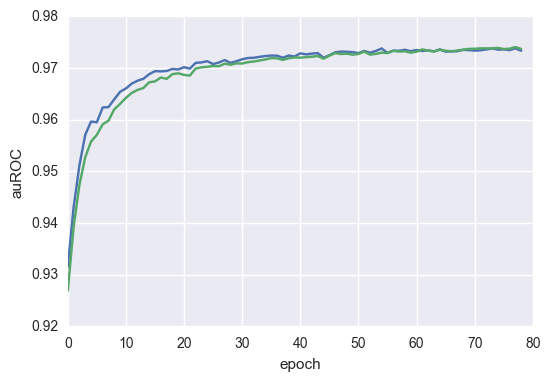

0.674326801071 0.97380387308
0 32 0.001 0.1 0.05 4
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_23 (Bidirectio (None, 70, 64)            9472      
_________________________________________________________________
bidirectional_24 (Bidirectio (None, 70, 64)            24832     
_________________________________________________________________
bidirectional_25 (Bidirectio (None, 70, 64)            24832     
_________________________________________________________________
bidirectional_26 (Bidirectio (None, 70, 64)            24832     
_________________________________________________________________
time_distributed_7 (TimeDist (None, 70, 1)             65        
Total params: 84,033.0
Trainable params: 84,033
Non-trainable params: 0.0
_________________________________________________________________
None
0 0.528690258001
1 0.583956012971
2 0.608769209079
3 0.612998731143
4 0.638939

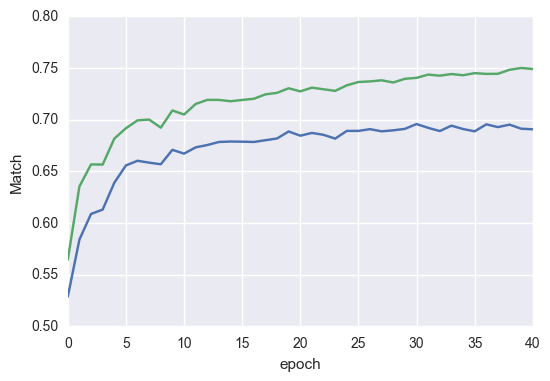

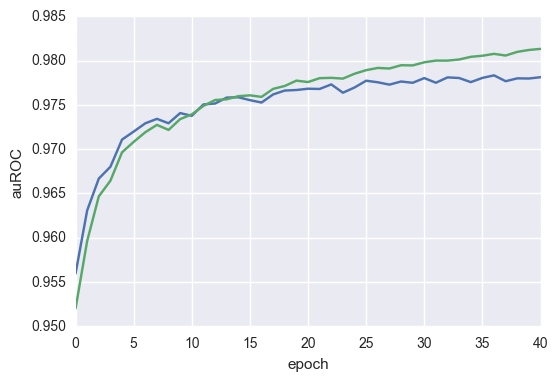

0.695756379529 0.978337238228
0 32 0.001 0.1 0.05 3
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_27 (Bidirectio (None, 70, 64)            9472      
_________________________________________________________________
bidirectional_28 (Bidirectio (None, 70, 64)            24832     
_________________________________________________________________
bidirectional_29 (Bidirectio (None, 70, 64)            24832     
_________________________________________________________________
time_distributed_8 (TimeDist (None, 70, 1)             65        
Total params: 59,201.0
Trainable params: 59,201
Non-trainable params: 0.0
_________________________________________________________________
None
0 0.528549273932
1 0.573946144086
2 0.601156069364
3 0.614126603694
4 0.630057803468
5 0.63922176794
6 0.642887353729
7 0.644861130692
8 0.658677569435
9 0.654589031439
10 0.665585788806
11 0.667136613563
12 0

KeyboardInterrupt: 

In [31]:
num_layers = [4, 3, 2, 1]
l2s = [0]
hiddens = [32, 24]
lrs = [0.001]
dropouts = [0.15, 0.1, 0.2]
r_dropouts = [0.05]

for l2 in l2s:
    for hidden in hiddens:
        for lr in lrs:
            for dropout in dropouts:
                for r_dropout in r_dropouts:
                    for num_layer in num_layers:
                        print l2, hidden, lr, dropout, r_dropout, num_layer
                        model = Sequential()
                        reg = regularizers.l2(l2)

                        model.add(Bidirectional(LSTM(hidden, return_sequences = True,
                                                     dropout = dropout, recurrent_dropout = r_dropout),
                                                     input_shape=(L, 4)))
                        for _ in range(num_layer-1):
                            model.add(Bidirectional(LSTM(hidden, return_sequences = True,
                                           dropout = dropout, recurrent_dropout = r_dropout)))

                        model.add(TimeDistributed(Dense(1, activation = 'sigmoid')))
                        model.compile(loss='binary_crossentropy',
                                      optimizer=optimizers.Adam(lr=lr,
                                                                beta_1=0.9,
                                                                beta_2=0.999,
                                                                epsilon=1e-08,
                                                                decay=0.0))
                        ModelTrainer(model).train(X_train, X_valid,
                                                  y_train.reshape(-1, 70, 1), y_valid.reshape(-1, 70, 1))

0.001 32 0.001 0.1 0.05 4
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_54 (Bidirectio (None, 70, 64)            9472      
_________________________________________________________________
bidirectional_55 (Bidirectio (None, 70, 64)            24832     
_________________________________________________________________
bidirectional_56 (Bidirectio (None, 70, 64)            24832     
_________________________________________________________________
bidirectional_57 (Bidirectio (None, 70, 64)            24832     
_________________________________________________________________
time_distributed_15 (TimeDis (None, 70, 1)             65        
Total params: 84,033.0
Trainable params: 84,033
Non-trainable params: 0.0
_________________________________________________________________
None
0 0.382771746793
1 0.569011701678
2 0.600028196814
3 0.617087269139
4 0.639785704215
5 0.646411955449
6

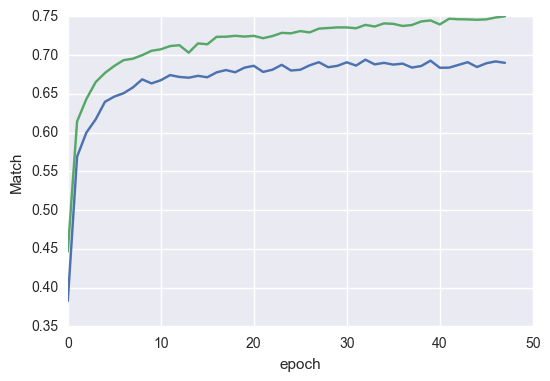

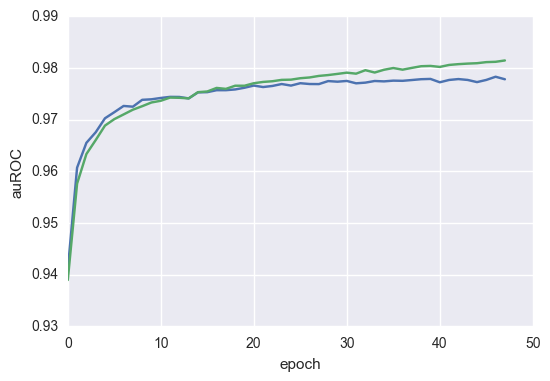

0.694064570704 0.978307972391
0.0001 32 0.001 0.1 0.05 4
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_58 (Bidirectio (None, 70, 64)            9472      
_________________________________________________________________
bidirectional_59 (Bidirectio (None, 70, 64)            24832     
_________________________________________________________________
bidirectional_60 (Bidirectio (None, 70, 64)            24832     
_________________________________________________________________
bidirectional_61 (Bidirectio (None, 70, 64)            24832     
_________________________________________________________________
time_distributed_16 (TimeDis (None, 70, 1)             65        
Total params: 84,033.0
Trainable params: 84,033
Non-trainable params: 0.0
_________________________________________________________________
None
0 0.481319610884
1 0.551670661215
2 0.590159311998
3 0.612998731143
4 0.

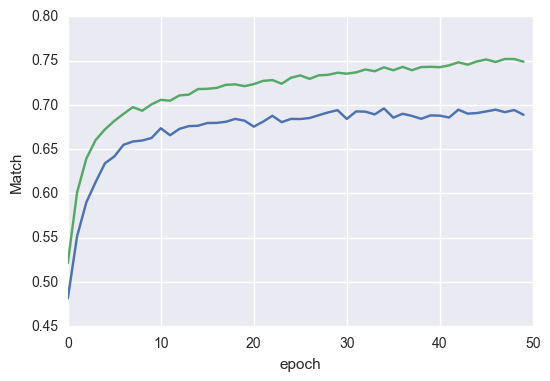

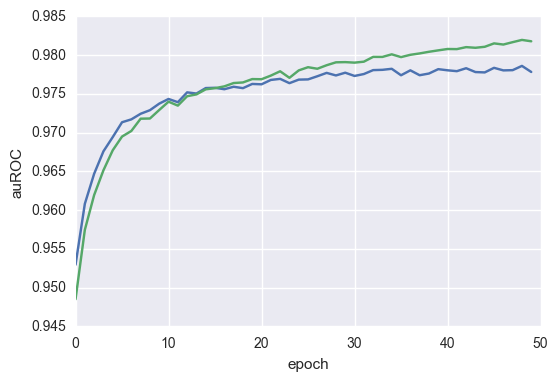

0.696038347667 0.978604305438
1e-05 32 0.001 0.1 0.05 4
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_62 (Bidirectio (None, 70, 64)            9472      
_________________________________________________________________
bidirectional_63 (Bidirectio (None, 70, 64)            24832     
_________________________________________________________________
bidirectional_64 (Bidirectio (None, 70, 64)            24832     
_________________________________________________________________
bidirectional_65 (Bidirectio (None, 70, 64)            24832     
_________________________________________________________________
time_distributed_17 (TimeDis (None, 70, 1)             65        
Total params: 84,033.0
Trainable params: 84,033
Non-trainable params: 0.0
_________________________________________________________________
None
0 0.427886648809
1 0.55223459749
2 0.581418299732
3 0.5969265473
4 0.6364

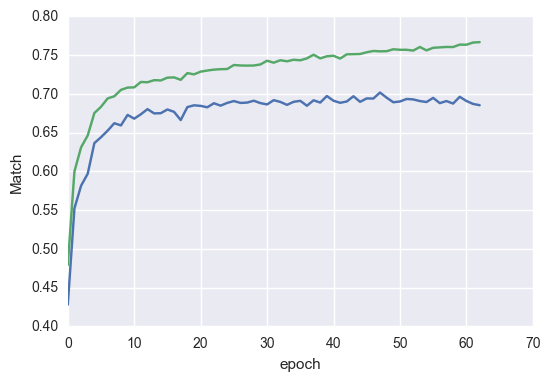

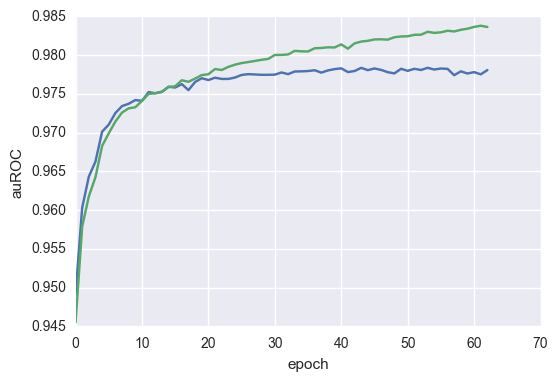

0.701677710419 0.978354932203


In [38]:
num_layers = [4]
l2s = [0.001, 0.0001, 0.00001]
hiddens = [32]
lrs = [0.001]
dropouts = [0.1]
r_dropouts = [0.05]

for l2 in l2s:
    for hidden in hiddens:
        for lr in lrs:
            for dropout in dropouts:
                for r_dropout in r_dropouts:
                    for num_layer in num_layers:
                        print l2, hidden, lr, dropout, r_dropout, num_layer
                        model = Sequential()
                        reg = regularizers.l2(l2)

                        model.add(Bidirectional(LSTM(hidden, return_sequences = True,
                                                     dropout = dropout, recurrent_dropout = r_dropout),
                                                     input_shape=(L, 4)))
                        for _ in range(num_layer-1):
                            model.add(Bidirectional(LSTM(hidden, return_sequences = True,
                                           dropout = dropout, recurrent_dropout = r_dropout)))

                        model.add(TimeDistributed(Dense(1, activation = 'sigmoid')))
                        model.compile(loss='binary_crossentropy',
                                      optimizer=optimizers.Adam(lr=lr,
                                                                beta_1=0.9,
                                                                beta_2=0.999,
                                                                epsilon=1e-08,
                                                                decay=0.0))
                        ModelTrainer(model).train(X_train, X_valid,
                                                  y_train.reshape(-1, 70, 1), y_valid.reshape(-1, 70, 1))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 70, 64)            9472      
_________________________________________________________________
bidirectional_2 (Bidirection (None, 70, 64)            24832     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 70, 64)            24832     
_________________________________________________________________
bidirectional_4 (Bidirection (None, 70, 64)            24832     
_________________________________________________________________
bidirectional_5 (Bidirection (None, 70, 64)            24832     
_________________________________________________________________
bidirectional_6 (Bidirection (None, 70, 64)            24832     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 70, 1)             65        
Total para

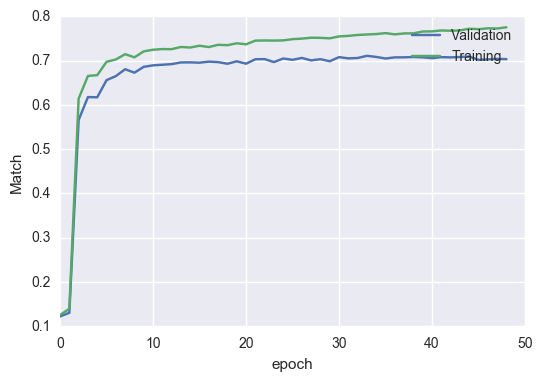

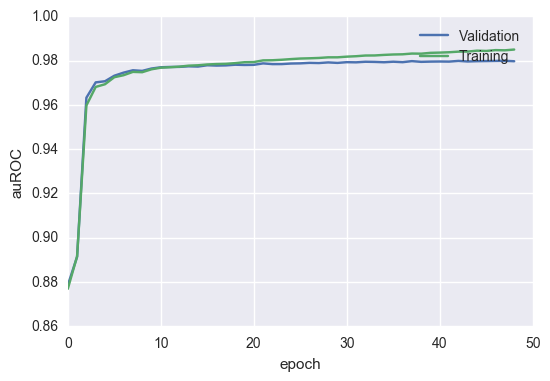

0.710841674891 0.979915404745


In [12]:
# Why not?
model = Sequential()
model.add(Bidirectional(LSTM(32, return_sequences = True,
                             dropout = 0.15, recurrent_dropout = 0.05),
                            input_shape = (L, 4)))
model.add(Bidirectional(LSTM(32, return_sequences = True,
                             dropout = 0.15, recurrent_dropout = 0.05)))
model.add(Bidirectional(LSTM(32, return_sequences = True,
                             dropout = 0.15, recurrent_dropout = 0.05),
                            input_shape = (L, 4)))
model.add(Bidirectional(LSTM(32, return_sequences = True,
                             dropout = 0.15, recurrent_dropout = 0.05)))
model.add(Bidirectional(LSTM(32, return_sequences = True,
                             dropout = 0.15, recurrent_dropout = 0.05),
                            input_shape = (L, 4)))
model.add(Bidirectional(LSTM(32, return_sequences = True,
                             dropout = 0.15, recurrent_dropout = 0.05)))

model.add(TimeDistributed(Dense(1, activation = 'sigmoid')))
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=0.001,
                                        beta_1=0.9,
                                        beta_2=0.999,
                                        epsilon=1e-08,
                                        decay=0.0))

ModelTrainer(model).train(X_train, X_valid,
                          y_train.reshape(-1, 70, 1), y_valid.reshape(-1, 70, 1))